<a href="https://colab.research.google.com/github/Diogoa83/Inteligencia-de-Mercado/blob/main/Convenio_Governo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mplcyberpunk
!pip install python-bcb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.2 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.27.1
    Uninstalling requests-2.27.1:
      Successfully uninstalled requests-2.27.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.27.1, but you have requests 2.31.0 which is incompatible.


In [2]:
import mplcyberpunk
import seaborn as sns
import pandas as pd
from bcb import sgs
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
from matplotlib.dates import date2num
from datetime import datetime
from datetime import timedelta
plt.style.use("cyberpunk")

In [3]:
import numpy as np
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot
import pandas.util.testing as tm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot

<ipython-input-3-533cb06baa56>:4: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [100]:
df_governo = pd.read_csv('/content/drive/MyDrive/Dados/convenio_GOVERNOS.csv', sep=';')
df_governo['Data'] = pd.to_datetime(df_governo['Data'], format='%d/%m/%Y')

In [101]:
df_governo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Data                    31 non-null     datetime64[ns]
 1   ValorBase               31 non-null     object        
 2   Selic                   31 non-null     object        
 3   taxa_mensal_consignado  31 non-null     object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.1+ KB


In [102]:
# Remover vírgula e converter coluna para float
df_governo['ValorBase'] = df_governo['ValorBase'].str.replace(',', '.').astype(float)
df_governo['Selic'] = df_governo['Selic'].str.replace(',', '.').astype(float)
df_governo['taxa_mensal_consignado'] = df_governo['taxa_mensal_consignado'].str.replace(',', '.').astype(float)

In [103]:
df_governo.head(4)

,Data,ValorBase,Selic,taxa_mensal_consignado
0,2020-12-01,501693.0,2.0,1.24
1,2021-01-01,1137781.0,2.0,1.26
2,2021-02-01,1467057.0,2.0,1.26
3,2021-03-01,2228465.0,2.0,1.27


In [104]:
df_governo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Data                    31 non-null     datetime64[ns]
 1   ValorBase               31 non-null     float64       
 2   Selic                   31 non-null     float64       
 3   taxa_mensal_consignado  31 non-null     float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 1.1 KB


In [105]:
df_governo.corr()

<ipython-input-105-23167bce90f7>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_governo.corr()


,ValorBase,Selic,taxa_mensal_consignado
ValorBase,1.000000,0.614297,0.554833
Selic,0.614297,1.000000,0.969828
taxa_mensal_consignado,0.554833,0.969828,1.000000


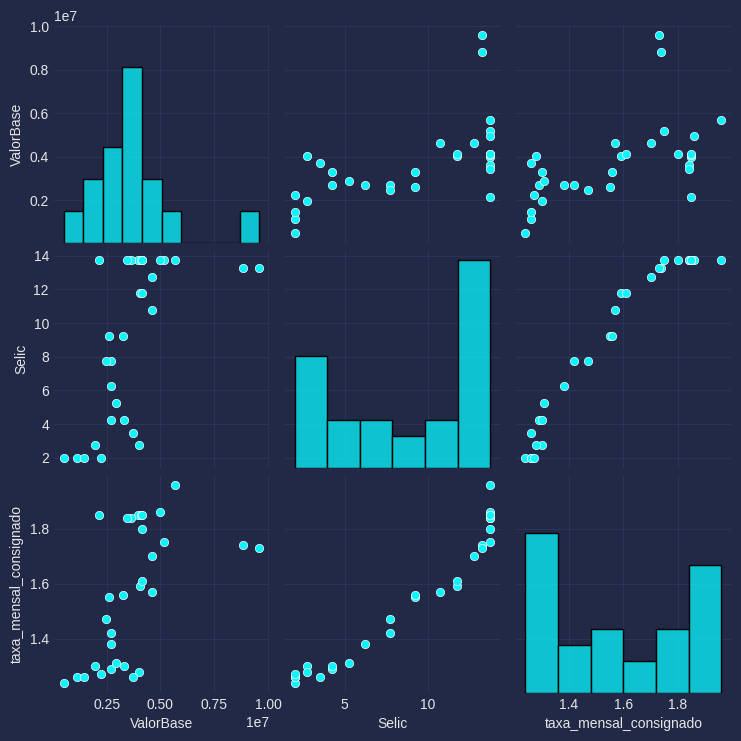

In [143]:
sns.pairplot(df_governo)

# MODELO ARIMA GOVERNO TREINO/TESTE

In [106]:
train_size = int(len(df_governo.ValorBase) * 2 / 3)
train_size

20

In [107]:
train_set = df_governo.ValorBase[:train_size]
test_set = df_governo.ValorBase[train_size:]

In [108]:
train_set.shape, test_set.shape

((20,), (11,))

In [109]:
train_set

0      501693.00
1     1137781.00
2     1467057.00
3     2228465.00
4     1953491.00
5     4017930.00
6     3701982.00
7     2709276.00
8     3314073.00
9     2913723.00
10    2707273.00
11    2694680.00
12    2454984.00
13    2607750.00
14    3281723.00
15    4625027.47
16    4031802.26
17    4129506.35
18    4618249.64
19    8812391.12
Name: ValorBase, dtype: float64

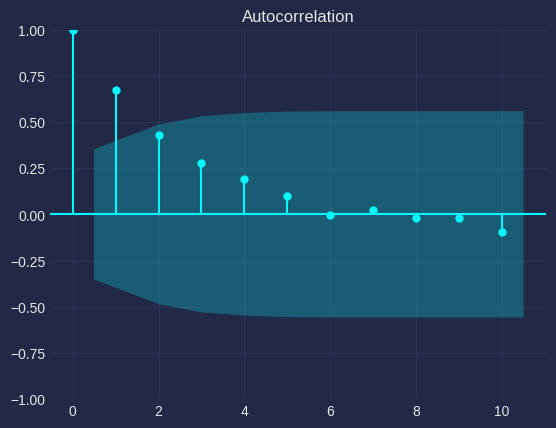

In [110]:
plot_acf(df_governo.ValorBase, lags=10)
pyplot.show()

In [ ]:
df_governo

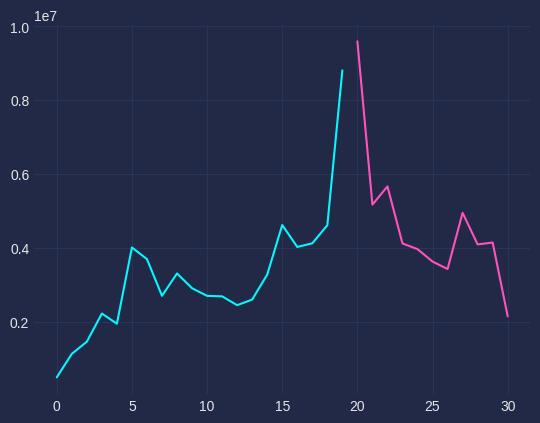

In [112]:
plt.plot(train_set)
plt.plot(test_set)

In [113]:
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.ar_model import AutoReg

ar_2 = AutoReg(train_set, lags=2).fit()
ar_2.params

const           159807.917403
ValorBase.L1         0.960475
ValorBase.L2         0.137801
dtype: float64

In [114]:
previsoes = ar_2.params[0] + test_set.shift(1) * ar_2.params[1] + test_set.shift(2) * ar_2.params[2]

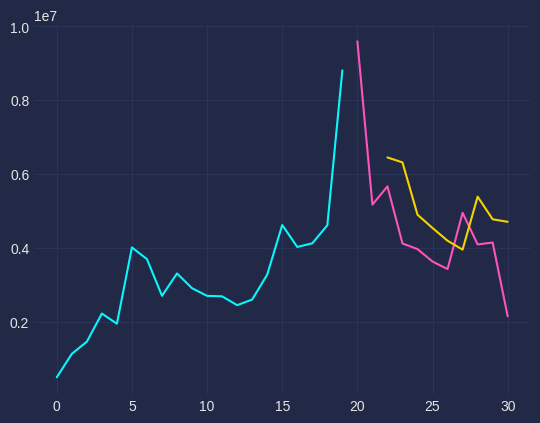

In [115]:
plt.plot(train_set)
plt.plot(test_set)
plt.plot(previsoes)

In [116]:
((test_set - previsoes) ** 2).mean()

1923844078735.033

# PREVISÕES SARIMAX CONVENIO GOVERNO

In [117]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [118]:
# Converter coluna de datas para o tipo datetime
df_governo['Data'] = pd.to_datetime(df_governo['Data'])

# Definir a coluna 'Data' como o índice do DataFrame
df_governo.set_index('Data', inplace=True)

In [139]:
df_governo.tail(5)

,ValorBase,Selic,taxa_mensal_consignado
Data,,,
2023-02-01,3433788.04,13.75,1.84
2023-03-01,4955990.50,13.75,1.86
2023-04-01,4099775.28,13.75,1.85
2023-05-01,4151516.36,13.75,1.85
2023-06-01,2154023.09,13.75,1.85


In [128]:
sarima = SARIMAX(df_governo.ValorBase, freq='MS', order=(2, 1, 2), seasonal_order=(2, 1, 1, 12)).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [141]:
print((sarima.resid).mean())

-12062.955744356292


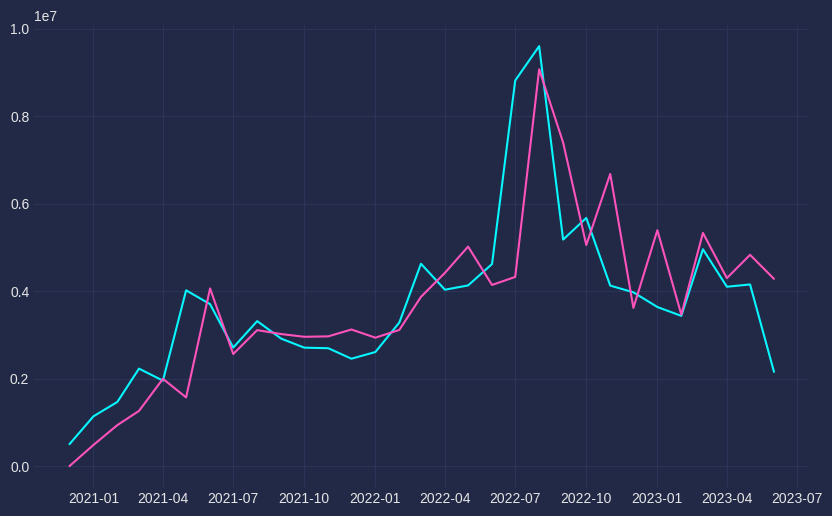

In [130]:
plt.figure(figsize=(10, 6))
plt.plot(df_governo.ValorBase)
plt.plot(sarima.predict(typ='levels'))

In [132]:
# Resultado da previsão

sarima.forecast()[0]

4456965.113210697

# PREVISÕES COM ARIMA CONVENIO GOVERNO

In [133]:
from statsmodels.tsa.arima.model import ARIMA


In [134]:
arima = ARIMA(df_governo['ValorBase'], order=(3, 1, 3))
arima_fit = arima.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Us

In [135]:
# Calcular o quadrado dos resíduos médios
mse = (arima_fit.resid ** 2).mean()
print(mse)

1602168918374.4255


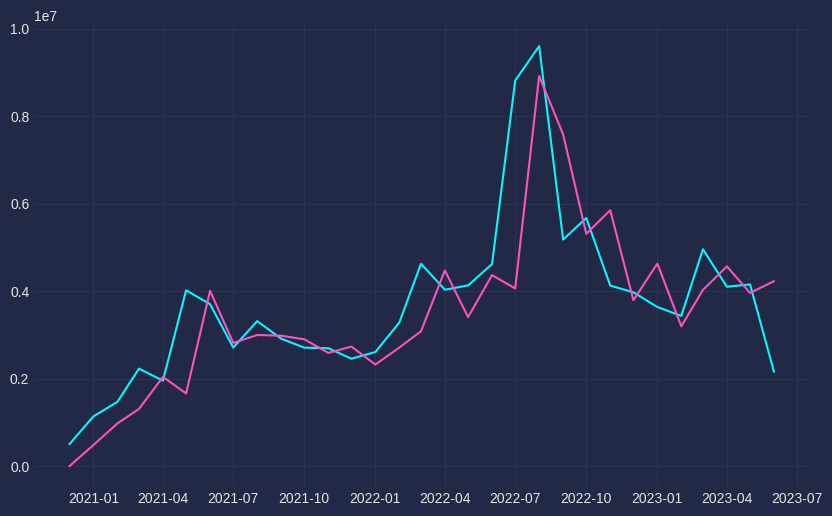

In [136]:
plt.figure(figsize=(10, 6))
plt.plot(df_governo.ValorBase)
plt.plot(arima_fit.predict(typ='levels'))

In [144]:
previsão = (arima_fit.forecast(steps=6).round())
arima_fit.forecast(steps=6).round()

2023-07-01    1946784.0
2023-08-01    2773918.0
2023-09-01    2494589.0
2023-10-01    2793660.0
2023-11-01    2662998.0
2023-12-01    2794191.0
Freq: MS, Name: predicted_mean, dtype: float64

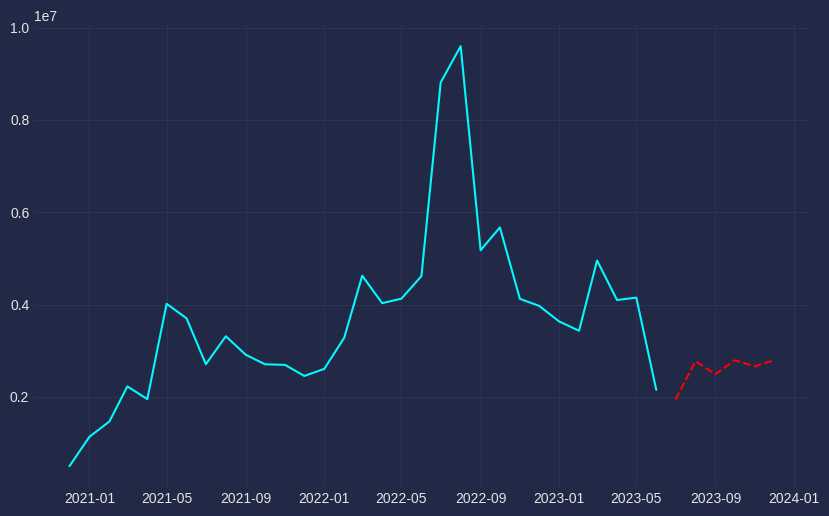

In [148]:
plt.figure(figsize=(10, 6))
plt.plot(df_governo.ValorBase)
plt.plot(previsão, color='red', linestyle='--', label='Previsão')

# Aplicando modelos com variáveis exógenas

In [81]:
p = 1
df1 = df_governo[['ValorBase']].copy()
for i in range(p):
    df1[f'x_{i+1}'] = df1.ValorBase.shift(i + 1)
df1.dropna(axis=0, inplace=True)
df1.head()

,ValorBase,x_1
Data,,
2021-01-01,1137781.0,501693.0
2021-02-01,1467057.0,1137781.0
2021-03-01,2228465.0,1467057.0
2021-04-01,1953491.0,2228465.0
2021-05-01,4017930.0,1953491.0


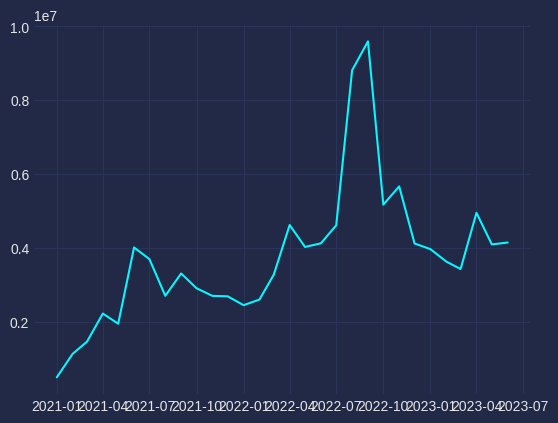

In [83]:
plt.plot(df1.x_1)

In [84]:
X = df1.drop('ValorBase', axis=1)
y = df1.ValorBase

In [85]:
# utilizando arvore de decision
from sklearn.tree import DecisionTreeRegressor

reg = DecisionTreeRegressor()
reg.fit(X, y)

DecisionTreeRegressor()

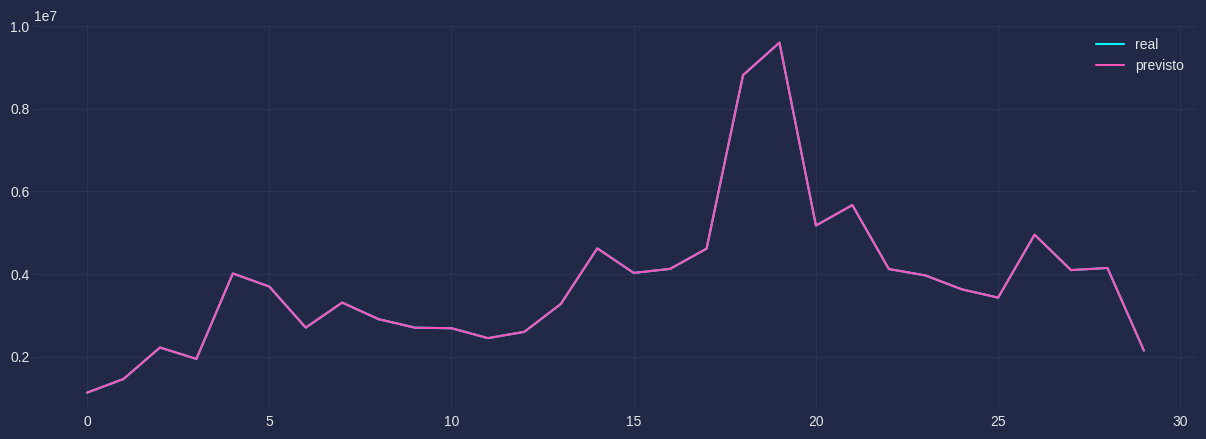

In [140]:
plt.figure(figsize=(15, 5))
plt.plot(df1.ValorBase.values)
plt.plot(reg.predict(X))
plt.legend(['real', 'previsto'])

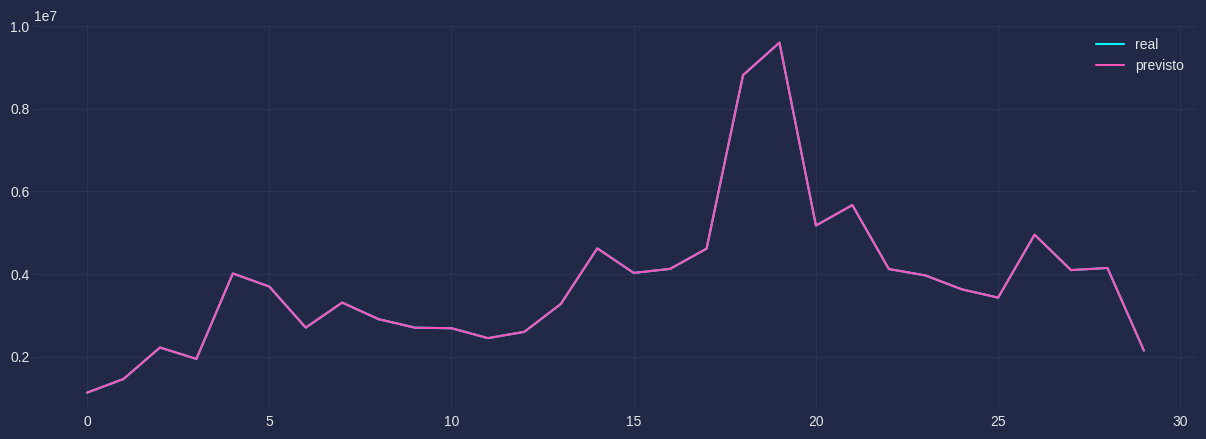

In [87]:
reg = DecisionTreeRegressor(max_depth=50)
reg.fit(X, y)
plt.figure(figsize=(15, 5))
plt.plot(df1.ValorBase.values)
plt.plot(reg.predict(X))
plt.legend(['real', 'previsto'])